In [1]:
__author__ = 'Erwin Chen'
# interact with plot
# %matplotlib nbagg
# simply show plot
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.io import fits
import numpy as np
import scipy.stats as stats
import scipy.cluster.hierarchy as h
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
import pickle

In [2]:
# load data from fits file
hdulist = fits.open('allStar-v603.fits')
hdulist.info()
tbdata = hdulist[1].data
# APOGEE ID for stars
apogee_ID = tbdata.field('APOGEE_ID')
# Galactic Longitude
l = tbdata.field('GLON')
# Galactic Latitude 
b = tbdata.field('GLAT')
# Right Ascension(J2000)
RA = tbdata.field('RA')
# Declination(J2000)
DEC = tbdata.field('DEC')
# Heliocentric radial velocity
RV = tbdata.field('VHELIO_AVG')
J = tbdata.field('J')
H = tbdata.field('H')
K = tbdata.field('K')
LOGG = tbdata.field('LOGG')
TEFF = tbdata.field('TEFF')
# Proper Motion
PMRA = tbdata.field('PMRA')
PMDEC = tbdata.field('PMDEC')
# 15 elements
elements = np.array(["Al", "Ca", "C", "Fe", "K", "Mg", "Mn", "Na", "Ni", "N", "O", "Si", "S", "Ti", "V"])
AL_H = tbdata.field("AL_H")
CA_H = tbdata.field("CA_H")
C_H = tbdata.field("C_H")
FE_H = tbdata.field('FE_H')
K_H = tbdata.field("K_H")
MG_H = tbdata.field("MG_H")
MN_H = tbdata.field("MN_H")
NA_H = tbdata.field("NA_H")
NI_H = tbdata.field("NI_H")
N_H = tbdata.field("N_H")
O_H = tbdata.field("O_H")
SI_H = tbdata.field("SI_H")
S_H = tbdata.field("S_H")
TI_H = tbdata.field("TI_H")
V_H = tbdata.field("V_H")
# errors for 15 elements
AL_H_ERR = tbdata.field("AL_H_ERR")
CA_H_ERR = tbdata.field("CA_H_ERR")
C_H_ERR = tbdata.field("C_H_ERR")
FE_H_ERR = tbdata.field("FE_H_ERR")
K_H_ERR = tbdata.field("K_H_ERR")
MG_H_ERR = tbdata.field("MG_H_ERR")
MN_H_ERR = tbdata.field("MN_H_ERR")
NA_H_ERR = tbdata.field("NA_H_ERR")
NI_H_ERR = tbdata.field("NI_H_ERR")
N_H_ERR = tbdata.field("N_H_ERR")
O_H_ERR = tbdata.field("O_H_ERR")
SI_H_ERR = tbdata.field("SI_H_ERR")
S_H_ERR = tbdata.field("S_H_ERR")
TI_H_ERR = tbdata.field("TI_H_ERR")
V_H_ERR = tbdata.field("V_H_ERR")
# get stars with 15 elements
C =  np.where(
        (LOGG > -9999.) * (TEFF > -9999.) * (RV < 999999.0) *
        (AL_H > -9999.) * (CA_H > -9999.) * (C_H > -9999.0) *
        (FE_H > -9999.) * (K_H > -9999.0) * (MG_H > - 9999.0) *
        (MN_H > -9999.) * (NA_H > -9999.0) * (NI_H > -9999.) *
        (N_H > -9999.) * (O_H > -9999.0) * (SI_H > -9999.) *
        (S_H > -9999.) * (TI_H > -9999.) * (V_H > -9999.))[0]

Filename: allStar-v603.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      15   ()              
1                BinTableHDU    324   163278R x 151C   [45A, 34A, 44A, 34A, 18A, 8A, I, 16A, E, E, E, E, E, E, D, D, D, D, J, J, 116A, J, I, E, J, 129A, J, 59A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 2E, 2E, 2E, 2E, 5A, 6A, 4A, I, 7E, 7E, 49E, 49E, 15E, 15E, 15E, 15E, E, E, E, E, E, E, E, E, E, 2A, J, 153A, 7J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, 15E, 15J, 18A, 12A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 17A, E, E, I, I, E, E, 20A, 737A, 665A, 50J, 50J]   
2                ImageHDU         6   (360,)       int32   
3                BinTableHDU     31   1R x 4C      [105A, 30A, 90A, 15I]   


In [3]:
# get chemical abundances of 15 elements for selected stars
def get_matrix(C):
    data = []
    data.append(C_H[C])
    data.append(FE_H[C])
    data.append(N_H[C])
    data.append(O_H[C])
    data.append(MG_H[C])
    data.append(SI_H[C])
    data.append(NI_H[C])
    data.append(AL_H[C])
    data.append(CA_H[C])
    data.append(MN_H[C])
    data.append(NA_H[C])
    data.append(S_H[C])
    data.append(K_H[C])
    data.append(TI_H[C])
    data.append(V_H[C])
    data = np.array(data)
    data = data.T
    return data

# get normalized chemical abundances of 15 elements for selected stars 
def get_matrix_normalized(C):
    data = []
    data.append(C_H[C] / np.mean(C_H_ERR[C]))
    data.append(FE_H[C] / np.mean(FE_H_ERR[C]))
    data.append(N_H[C] / np.mean(N_H_ERR[C]))
    data.append(O_H[C] / np.mean(O_H_ERR[C]))
    data.append(MG_H[C] / np.mean(MG_H_ERR[C]))
    data.append(SI_H[C] / np.mean(SI_H_ERR[C]))
    data.append(NI_H[C] / np.mean(NI_H_ERR[C]))
    data.append(AL_H[C] / np.mean(AL_H_ERR[C]))
    data.append(CA_H[C] / np.mean(CA_H_ERR[C]))
    data.append(MN_H[C] / np.mean(MN_H_ERR[C]))
    data.append(NA_H[C] / np.mean(NA_H_ERR[C]))
    data.append(S_H[C] / np.mean(S_H_ERR[C]))
    data.append(K_H[C] / np.mean(K_H_ERR[C]))
    data.append(TI_H[C] / np.mean(TI_H_ERR[C]))
    data.append(V_H[C] / np.mean(V_H_ERR[C]))
    data = np.array(data)
    data = data.T
    return data

# plot chemical abundance
def plot_chem(stars, title):
    # get stars with all 15 elements
    C = np.where(
            (LOGG > -9999.) * (TEFF > -9999.) * (RV < 999999.0) *
            (AL_H > -9999.) * (CA_H > -9999.) * (C_H > -9999.0) *
            (FE_H > -9999.) * (K_H > -9999.0) * (MG_H > - 9999.0) *
            (MN_H > -9999.) * (NA_H > -9999.0) * (NI_H > -9999.) *
            (N_H > -9999.) * (O_H > -9999.0) * (SI_H > -9999.) *
            (S_H > -9999.) * (TI_H > -9999.) * (V_H > -9999.))[0]
    # get members with all 15 elements
    stars = np.intersect1d(C, stars)
    # get data matrix
    data = get_matrix(stars)
    # plot chemical abundance
    f, ax = plt.subplots()
    x = range(1,16)
    for n in range(stars.size):
        ax.plot(x, data[n])
    ax.set_title(title)
    ax.set_xlabel("elements")
    ax.set_ylabel("[X/H](dex)")
    ax.set_xticks(x)
    ax.set_xticklabels(elements, x=x)
    ax.set_ylim(-2.5, 1)
    plt.show()

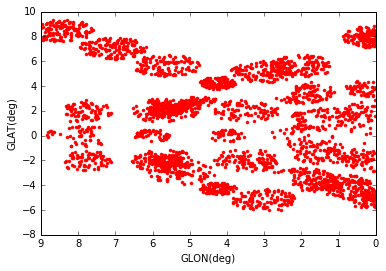

In [4]:
# bulge
bulge = np.where((-8 < b) * (b < 10) * (l < 9))[0]
bulge = np.intersect1d(bulge, C)
# plot bulge
plt.plot(l[bulge],b[bulge],"r.")
plt.xlabel("GLON(deg)")
plt.ylabel("GLAT(deg)")
plt.xlim(9, 0)
plt.show()

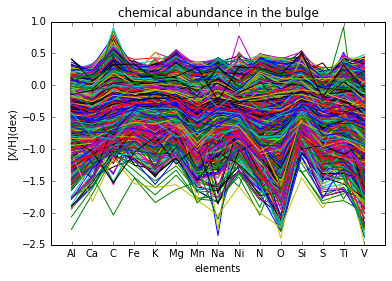

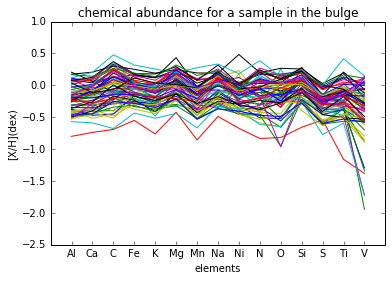

In [5]:
# plot chemical abundance in the bulge
plot_chem(bulge, "chemical abundance in the bulge")
# plot chemical abundance of a sample in the bulge
bulge_sample = np.random.random_integers(0, bulge.size, 100)
plot_chem(bulge_sample, "chemical abundance for a sample in the bulge")

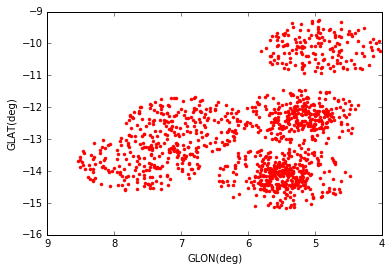

In [6]:
# Sagittarius A
# bulge
Sg_A = np.where((l < 14) * (b < -8))[0]
Sg_A = np.intersect1d(Sg_A, C)
# plot bulge
plt.plot(l[Sg_A],b[Sg_A],"r.")
plt.xlim(9, 4)
plt.xlabel("GLON(deg)")
plt.ylabel("GLAT(deg)")
plt.show()

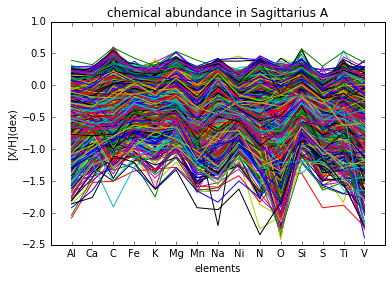

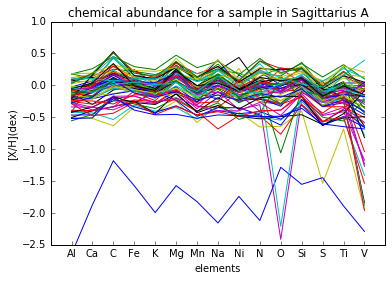

In [7]:
# plot chemical abundance in Sagittarius A
plot_chem(Sg_A, "chemical abundance in Sagittarius A")
# plot chemical abundance of a sample in Sagittarius A
Sg_A_sample = np.random.random_integers(0, Sg_A.size, 100)
plot_chem(Sg_A_sample, "chemical abundance for a sample in Sagittarius A")

In [8]:
print Sg_A.size, bulge.size

1161 3070


there are 4231 stars in the bulge and Sagittarius A
41 Kmeans groups found


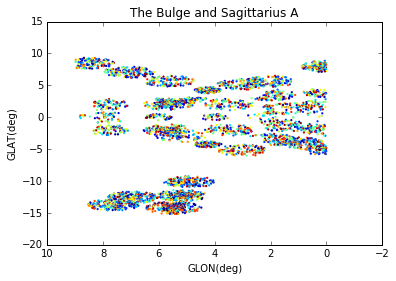

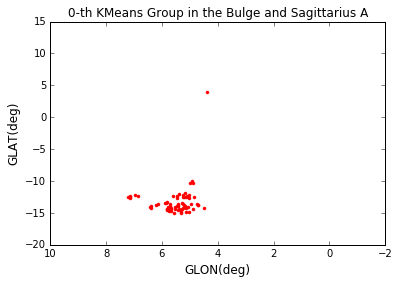

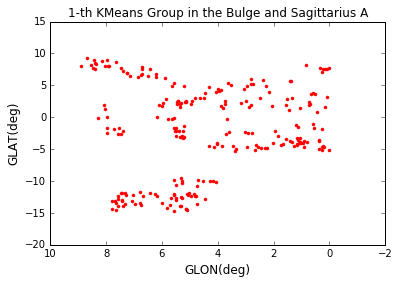

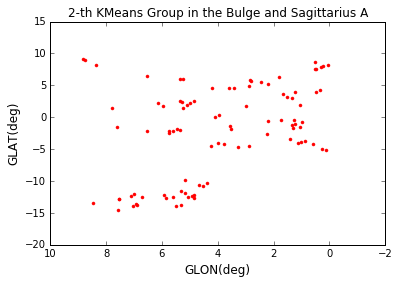

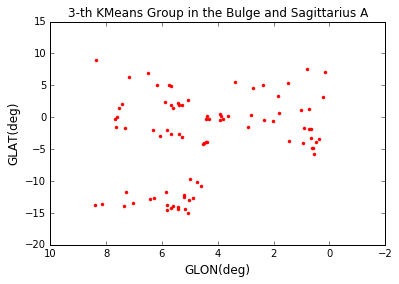

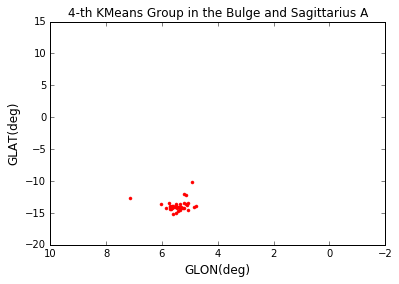

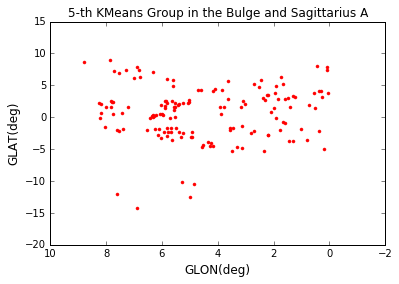

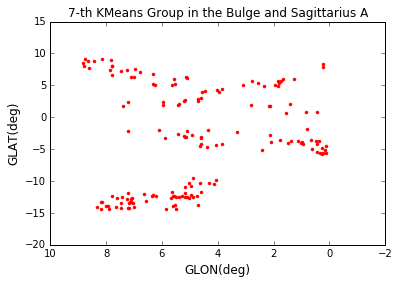

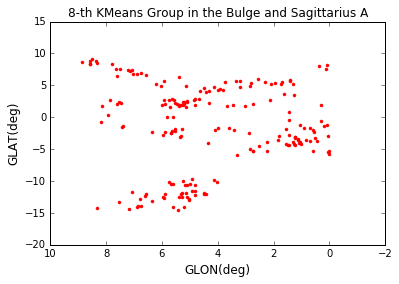

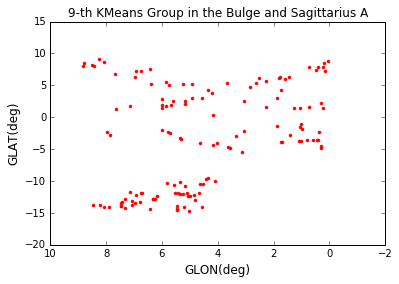

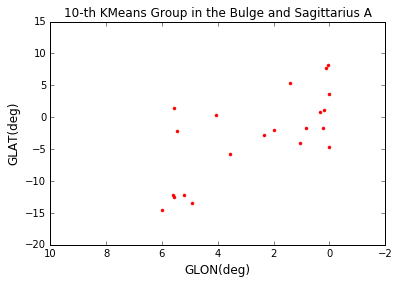

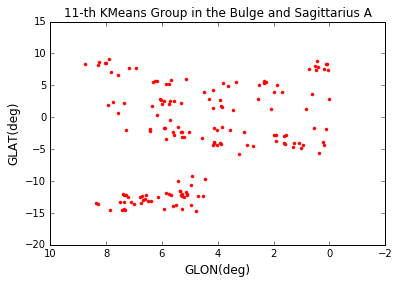

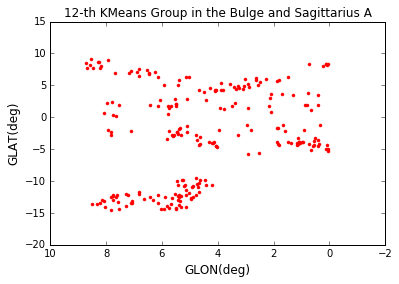

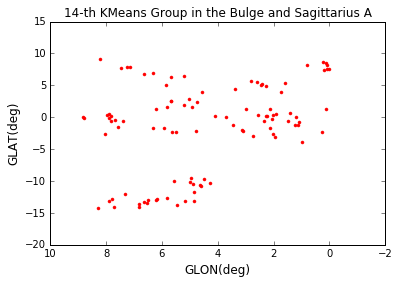

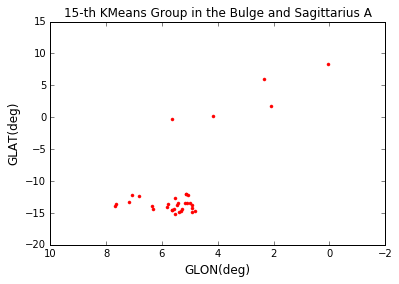

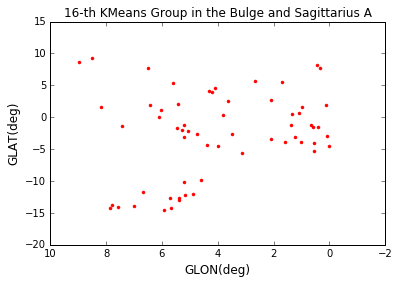

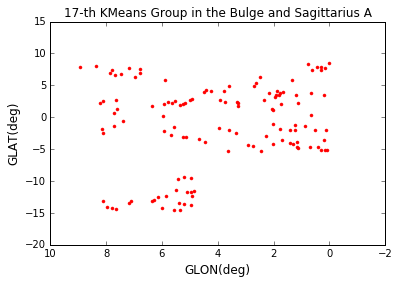

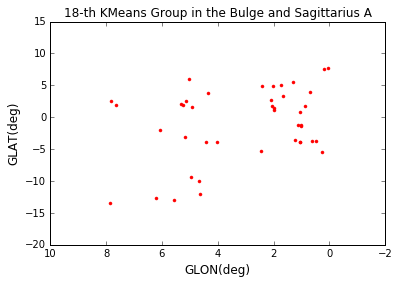

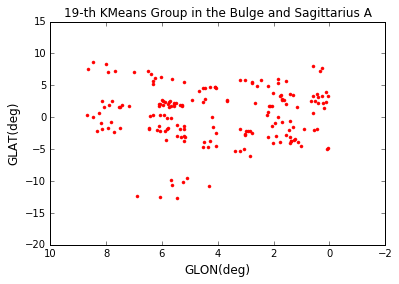

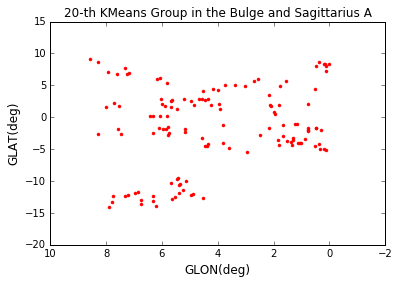

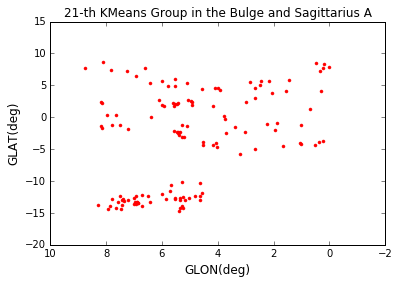

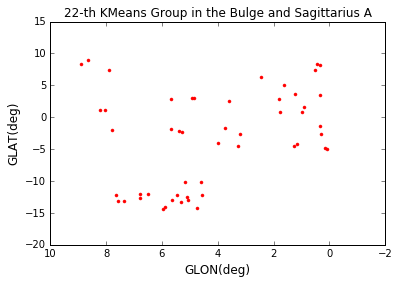

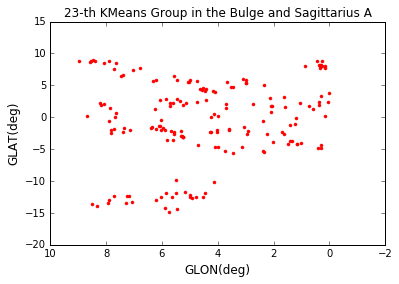

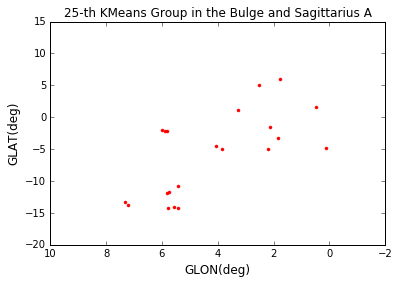

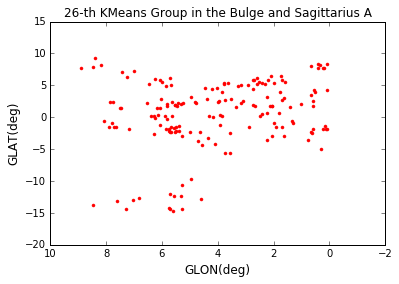

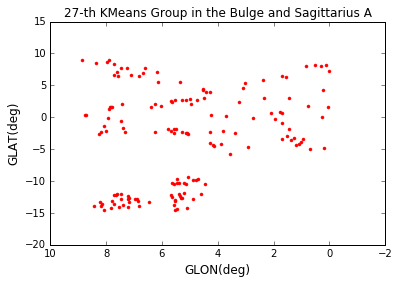

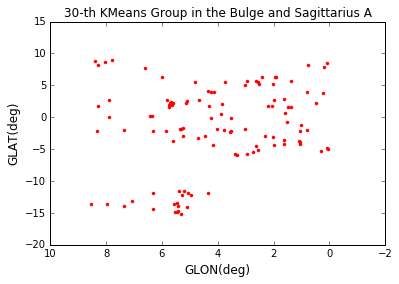

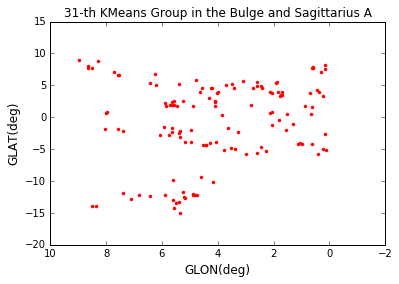

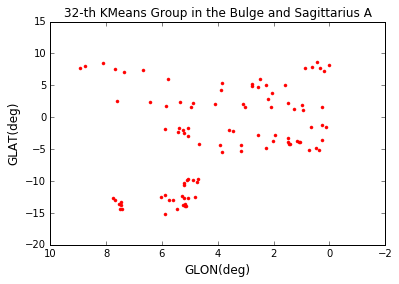

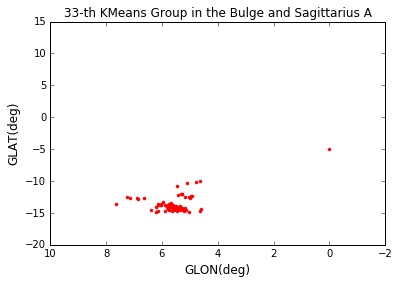

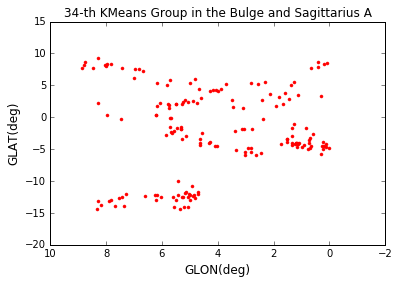

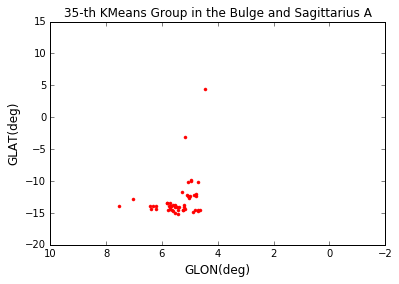

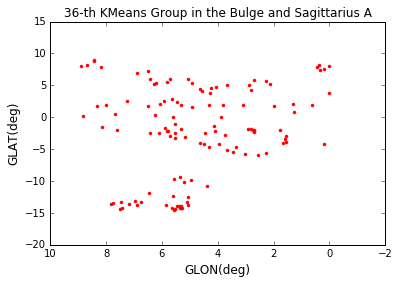

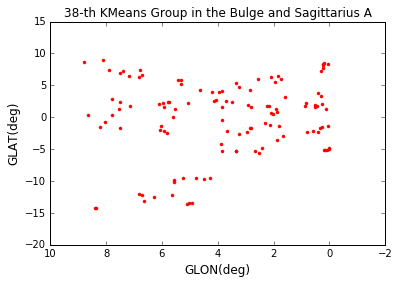

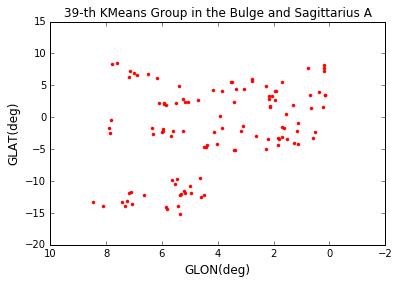

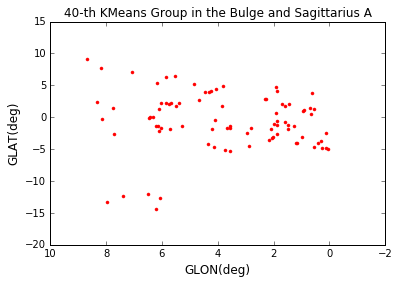

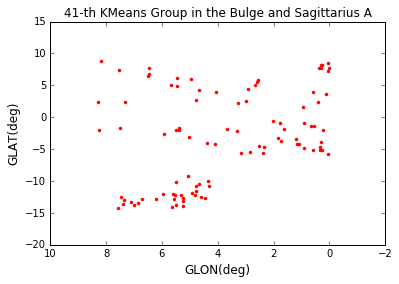

In [9]:
stars = np.concatenate((Sg_A, bulge))
print "there are %i stars in the bulge and Sagittarius A"%stars.size
data = get_matrix_normalized(stars)
kmeans = KMeans(n_clusters=stars.size/100, n_init=10)
kmeans.fit(data)
labels = kmeans.labels_
print "%i Kmeans groups found"%labels.max()
plt.scatter(l[stars], b[stars], c=labels, s=5, linewidth=0)
plt.title("The Bulge and Sagittarius A")
plt.xlabel("GLON(deg)")
plt.ylabel("GLAT(deg)")
plt.xlim(10,-2)
plt.ylim(-20, 15)
plt.show()
for n in range(labels.max()+1):
    group_stars = stars[np.where(labels == n)[0]]
    if group_stars.size > 20:
        fig = plt.figure()
        plt.plot(l[group_stars], b[group_stars], "r.")
        plt.title("%i-th KMeans Group in the Bulge and Sagittarius A"%n)
        plt.xlabel("GLON(deg)", fontsize=12)
        plt.ylabel("GLAT(deg)", fontsize=12)
        plt.xlim(10,-2)
        plt.ylim(-20, 15)
        plt.show()